In [1]:
from utils import read_dataset, drop_useless
import matplotlib.pyplot as plt 
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
# Reading all the data from healthy subject "Finn"
SUBJECT = "Finn"
dataset = read_dataset(SUBJECT,
                       # timestamp="10-12-24",
                       read_ort=False)

# Filling data if joint angles are not calculatable - max fill 1sec 
for nd in dataset:
    nd.fill(1.0)
# cutting data apart and leaving out if joint angle have massiv shifts -> most certainly markers are swapped
dataset = drop_useless(dataset)
# applying moving average filter on emg and joint angle data 
for nd in dataset: 
    nd.moving_average_filter(10, on="joints")

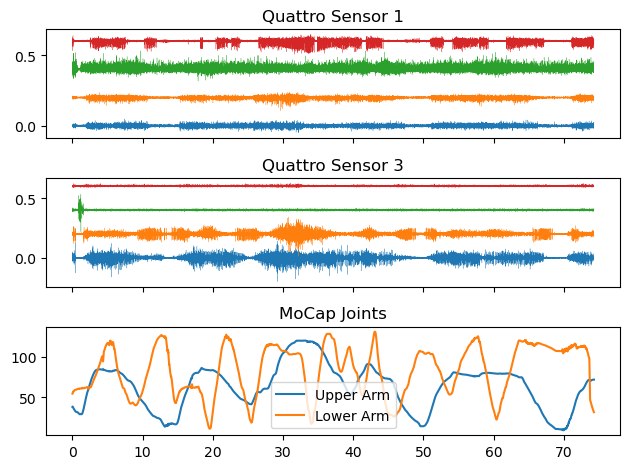

In [3]:
dataset[0].plot(plot_emg=True, plot_mocap_joints=True)

In [4]:
# shuffle dataset but keep trails as they are - this ensures test data gets from different recordings sessions

len(dataset)
shuffle_indices = np.arange(len(dataset))
np.random.seed(100)
np.random.shuffle(shuffle_indices)
dataset = [dataset[i] for i in shuffle_indices]

In [5]:
# split off test_data - will stay untouched until evaluation of models 

joints_samples = sum([data.mocap_joints.shape[0] for data in dataset])
train_indices, test_indices = [], []
x = 0
for i, data in enumerate(dataset):
    if x >= joints_samples * 0.9: 
        test_indices.append(i)
    else: 
        train_indices.append(i)
    x += data.mocap_joints.shape[0]

test_data = [dataset[i] for i in test_indices]
train_data = [dataset[i] for i in train_indices]

In [6]:
def prepare_data(data, every: int, tail_mocap: int, tail_emg: int, mocap_future: int):
    f_joints, *_, f_emg = zip(*[x.get_data(every, tail_mocap, tail_emg, mocap_future) for x in data])
    f_joints = [fj.reshape(-1, 2) for fj in f_joints]
    return f_joints, f_emg
    
# joints, emg_data = prepare_data(train_data, 10, 1, 444, 50)
# joints[1].shape, emg_data[1].shape

In [7]:
# nielsen et al. mean absolute value, zero-crossings, slope signs changes and waveform length
# https://sci-hub.ru/10.1109/icaccaf.2016.7748960

def get_feature_vector(f_emg, *features, lag=1): 
    """ Extracts features from emg data, lag needs to correspond to win size """
    if lag < 1: 
        raise ValueError(f"Lag should at least be 1, you passed {lag}")
    if not features: 
        raise ValueError("No features passed in")
    features = [(feat.lower(), None) if type(feat) == str else (feat[0].lower(), feat[1]) for feat in features]
    feat_vecs = []
    for emg in f_emg: 
        new_shape = list(emg.shape)
        new_shape[1] = int(new_shape[1] / lag)
        new_shape.insert(1, lag)
        emg = emg.reshape(*new_shape)
        fv = []
        for feat, arg in features:
            match feat: 
                case "mav": 
                    fv.append(np.mean(np.abs(emg), axis=2))
                case "rms": 
                    fv.append(np.sqrt(np.mean(emg ** 2, axis=2)))
                case "wl": 
                    fv.append(np.sum(np.abs(np.diff(emg, axis=2)), axis=2))
                case "zc": 
                    x_n = emg[..., :-1, :]
                    x_n_p1 = emg[..., 1:, :]
                    fv.append(np.count_nonzero((x_n * x_n_p1 < 0) * (np.abs(x_n - x_n_p1) > arg), axis=2))
                case "ssc": 
                    x_n = emg[..., 1:-1, :]
                    x_n_m1 = emg[..., :-2, :]
                    x_n_p1 = emg[..., 2:, :]
                    fv.append(np.count_nonzero(
                        (x_n - x_n_m1) * (x_n - x_n_p1) * ((x_n - x_n_m1) > arg) * ((x_n - x_n_p1) > arg), axis=2))
        feat_vecs.append(np.dstack(fv))
    return feat_vecs
    

In [8]:
# norm every feature, channel separatly 
from typing import Literal

def norm_emg_data(feat_vec, type_: Literal["z", "min_max"] = "min_max"): 
    """ Norms every feature and every channel """
    conc = np.vstack(feat_vec)
    if type_ == "min_max": 
        min_ = np.min(conc, axis=(0, 1))
        max_ = np.max(conc, axis=(0, 1))
        norm_vals = (min_, max_)
        feat_vec = [(fv - min_) / (max_ - min_) for fv in feat_vec]
    elif type_ == "z": 
        mu = np.mean(conc, axis=(0, 1))
        sigma = np.std(conc, axis=(0, 1))
        norm_vals = (mu, sigma)
        feat_vec = [(fv - mu) / sigma for fv in feat_vec] 
    else: 
        raise NotImplemetedError
    return feat_vec, norm_vals


In [9]:
# norm joints
def norm_joints(j): 
    conc = np.vstack(j)
    max_ = np.max(conc)
    min_ = np.min(conc)
    return [(nj - min_) / (max_ - min_) for nj in j], (min_, max_)

In [10]:
from tensorflow import keras
from keras.models import Sequential, clone_model
from keras.layers import LSTM, Dense, Dropout, Input, Flatten, LeakyReLU
from keras.optimizers import Adam

def create_model(input_shape):
    """ Creates a model using EMG-features as input, I am going to use feedforward instead of lstm here
    because depending on lag time steps are very small. One could also use 1d-cnn for lag > 1"""
    activation = LeakyReLU()
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activation))
    model.add(Dense(16, activation=activation))
    model.add(Dense(2, activation=activation, name="output"))
    return model


E0000 00:00:1738266732.409822  761425 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738266732.412078  761425 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

def train_model(m, inputs_train, inputs_val, targets_train, targets_val, *, 
                learning_rate,
                batch_size, 
                epochs, 
                path, 
                early_stop_patience: int or None = None): 
    """ trains a model based on inputs, saves training history and best model as specified by path"""
    callbacks = [ModelCheckpoint(os.path.join(path, "best_model.keras"), monitor="val_loss", save_best_only=True, mode="min"), 
                 CSVLogger(os.path.join(path, "model_history_log.csv"), append=False)]
    if early_stop_patience is not None: 
        callbacks.append(EarlyStopping(patience=early_stop_patience))
    
    optimizer = Adam(learning_rate=learning_rate)
    m.compile(optimizer=optimizer, loss="mse")
    history = m.fit(inputs_train, targets_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(inputs_val, targets_val), callbacks=callbacks)
    return history, m

In [12]:
def get_hyperparameters(parent_dir: str or os.Pathlike): 
    """ In a parent directory looks into all models and finds reads the hyperparameters trained on """
    i = 1
    hyperparamets = []
    parent_path = os.path.join("models", SUBJECT, parent_dir)
    if not os.path.exists(parent_path): 
        return []
    for model_name in os.listdir(parent_path):
        if model_name.startswith("."): 
            continue
        with open(os.path.join(parent_path, model_name, "info.txt")) as file:
            params = {}
            for line in file.readlines(): 
                if line == "\n": 
                    break
                key, val = line.split(":")
                key = key.strip()
                val = eval(val)
                params[key] = val
        hyperparamets.append(params)
    return hyperparamets

In [13]:
def get_directory(parent_dir: str or os.Pathlike): 
    """ In a parent directory finds next free dir and creates it """
    i = 1
    while True: 
        path = os.path.join("models", SUBJECT, parent_dir, f"model{i:03}")
        if not os.path.exists(path):
            os.makedirs(path)
            break
        i += 1
    return path

def write_info(path, norm_vals, norm_vals_targets, **info): 
    """ save everything needed for reproduction """
    with open(os.path.join(path, "info.txt"), "w+") as file:
        for key, val in info.items(): 
            file.write(f"{key} : {val} \n")
        file.write("\n")
        file.write(f"min_joints: {norm_vals_targets[0]}\n")
        file.write(f"max_joints: {norm_vals_targets[1]}\n")
        for vals in norm_vals: 
            file.write("\n")
            np.savetxt(file, vals)
            file.write("\n")

In [14]:
# grid search base on: lag, features_combination, batch_size, learning rate
# mean absolute value, zero-crossings, slope signs changes and waveform length
import os 
from itertools import product


def grid_search_feat_extr(): 
    """ Preform a grid search. Different Parameters are tuned """ 
    lags = (1, 3)
    feat_sets = (
        # ("rms", ("zc", 3e-3), ("ssc", 3e-4)), 
        ("rms", ), 
        # ("mav", ("ssc", 3e-4)), 
        ("mav", ("zc", 3e-3), ("ssc", 3e-4), "wl")
    )
    lrs = (1e-4, )
    btch_sizes = (32,)

    for lag, features, learning_rate, batch_size in product(lags, feat_sets, lrs, btch_sizes): 
        parameter_set = {"lag": lag, "features": features, "learning_rate": learning_rate, "batch_size": batch_size}
        if any(parameter_set == params for params in get_hyperparameters("feat_ex_models")): 
            print("hyperparameter set already exists")
            continue
        path = get_directory("feat_ex_models")
        print(f"model at {path} with lag: {lag}, features: {features}, learing_rate: {learning_rate}, batch_size: {batch_size}")
        
        # get feature vector and norm data
        targets, inputs = prepare_data(train_data, 10, 1, 222 * lag, 50)
        
        inputs = get_feature_vector(inputs, *features, lag=lag)
        inputs, norm_vals = norm_emg_data(inputs, "z")
        targets, norm_vals_targets = norm_joints(targets)

        write_info(path, norm_vals, norm_vals_targets, **parameter_set)
        
        # prepare inputs and targets: shuffle data - split off validation set 
        
        inputs = np.vstack(inputs)
        targets = np.vstack(targets)
        shuf_ind = np.arange(inputs.shape[0])
        np.random.seed(5)
        np.random.shuffle(shuf_ind)
    
        inputs = inputs[shuf_ind]
        targets = targets[shuf_ind]
        
        inputs_train, inputs_val = np.split(inputs, (int(inputs.shape[0] * 0.85), ))
        targets_train, targets_val = np.split(targets, (int(targets.shape[0] * 0.85), ))
        
        # train the model
        
        m = create_model((lag, len(features) * 8))
        train_model(m, inputs_train, inputs_val, targets_train, targets_val, 
                    learning_rate=learning_rate, 
                    batch_size=batch_size, 
                    path=path, 
                    epochs=1000, 
                    early_stop_patience=50)
        

grid_search_feat_extr()

hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists
hyperparameter set already exists


In [15]:
from typing import Sequence
from scipy.signal import resample_poly
from scipy.ndimage import uniform_filter1d

def emg_filter_downsample(f_emg: Sequence[np.ndarray], filter_time: float, downsample_factor: float = 1.0): 
    """ Downsamples the EMG signal as sample rate is very high, applies rectification and moving average filter """
    filter_period = round(2222e-3 * filter_time / downsample_factor)
    if downsample_factor < 1: 
        raise ValueError("Downsample factor needs to be greater or equal 1")
    data = []
    for emg in f_emg: 
        x = resample_poly(emg, 1, downsample_factor, axis=1)
        x = uniform_filter1d(np.abs(x), size=filter_period, axis=1)
        data.append(x)
    return data
        

In [16]:
from typing import Tuple

def create_direct_model(lstm_layer: Tuple[int, int], input_shape: Tuple[int, int]): 
    """ Creates a model with lstm layer to directly extract features from EMG signal """ 
    activation = LeakyReLU() # because EMG signal might be z-score normed
    model = Sequential()
    model.add(Input(input_shape))
    model.add(LSTM(lstm_layer[0], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_layer[1]))
    model.add(Dense(32, activation=activation))
    model.add(Dense(8,  activation=activation))
    model.add(Dense(2, activation=activation))
    return model 


In [17]:
def grid_search_direct_model():
    lags = (1, )
    f_times = (20, )
    down_facs = (1, 2)
    btch_sizes = (32, ) 
    l_rates = (1e-4, ) 
    lstm_layers = ((64, 32), ) # , (128, 64))

    for lag, down_fac, f_time, batch_size, learning_rate, lstm in product(lags, down_facs, f_times, btch_sizes, l_rates, lstm_layers): 
        
        parameter_set = {"lag": lag, 
                         "downsample_factor": down_fac, 
                         "filter_time": f_time, 
                         "lstm_layers": lstm, 
                         "learning_rate": learning_rate, 
                         "batch_size": batch_size}
        if any(parameter_set == params for params in get_hyperparameters("direct_models")): 
            print("hyperparameter set already exists")
            continue
            
        path = get_directory("direct_models")
        print(f"model at {path} lag: {lag}, downsampling_factor: {down_fac}, filter_time: {f_time} ms", 
              f"batch_size: {batch_size}, learning_rate: {learning_rate}, lstm_layers: {lstm}")

        # get data
        targets, inputs = prepare_data(train_data, 10, 1, lag * 222, 50)
        targets, norm_vals_targets = norm_joints(targets)
        inputs = emg_filter_downsample(inputs, f_time, down_fac)
        inputs, norm_vals = norm_emg_data(inputs, "z")

        write_info(path, norm_vals, norm_vals_targets, **parameter_set)

        # shuffle data and split of validation data 
        inputs = np.vstack(inputs)
        targets = np.vstack(targets)
        shuffle_indices = np.arange(inputs.shape[0])
        np.random.seed(100)
        np.random.shuffle(shuffle_indices) 
        inputs = inputs[shuffle_indices]
        targets = targets[shuffle_indices]
        split = (int(inputs.shape[0] * 0.85), )
        inputs_train, inputs_val = np.split(inputs, split)
        targets_train, targets_val = np.split(targets, split)

        # create and train model 
        m = create_direct_model(lstm, inputs_train.shape[1:])
        train_model(m, inputs_train, inputs_val, targets_train, targets_val, 
                    learning_rate=learning_rate, 
                    batch_size=batch_size, 
                    path=path, 
                    epochs=1000, 
                    early_stop_patience=50)


grid_search_direct_model()

hyperparameter set already exists
hyperparameter set already exists


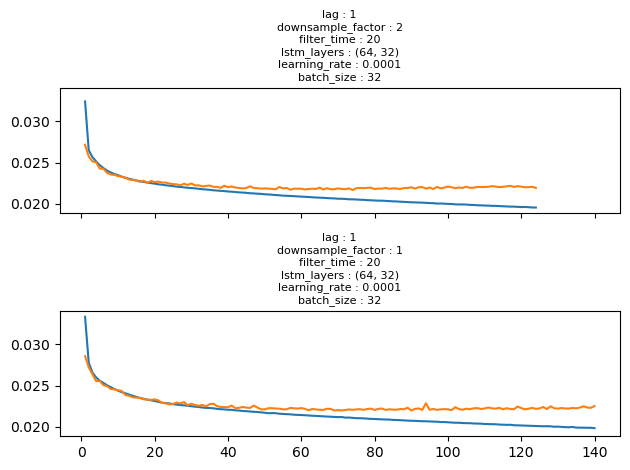

In [18]:
def plot_history(*parent_dir: str or os.Pathlike): 
    if not parent_dir: 
        raise ValueError("Please insert parent dir param")
    history = []
    param_sets = []
    for dir_ in parent_dir: 
        parent_path = os.path.join("models", SUBJECT, dir_)
        param_sets += get_hyperparameters(dir_)
        for name in os.listdir(parent_path): 
            history.append(np.genfromtxt(os.path.join(parent_path, name, "model_history_log.csv"), delimiter=","))
    rows = np.sqrt(len(history))
    rows, rem = int(rows // 1), rows % 1
    cols = rows
    if rem: 
        rows += 1
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, squeeze=False)
    for ax, hist, params in zip(axs.flatten(), history, param_sets): 
        ax.plot(hist[:, 1:])
        title = ""
        for i, (key, val) in enumerate(params.items()): 
            title += f"{key} : {val}"
            if i != len(params) - 1: 
                title += "\n"
        ax.set_title(title, fontsize=8)


plot_history("direct_models")
plt.tight_layout()

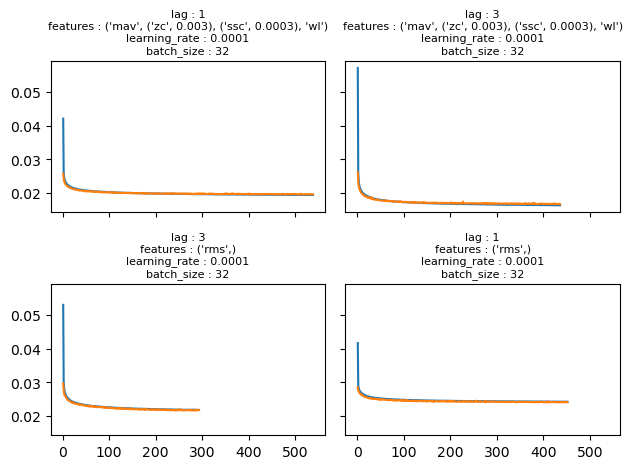

In [19]:
plot_history("feat_ex_models")
plt.tight_layout()

In [20]:
# from keras.models import load_model
from tensorflow.keras.saving import load_model

def read_norm_vals(path): 
    path = os.path.join(path, "info.txt")
    count = 0
    with open(path, "r") as file: 
        x = []
        for line in file.readlines(): 
            if line == "\n" and x: 
                yield x
                x = []
                continue
            if line.strip(): 
                x.append(line.strip())

def predict(parent_dir): 
    hyper_params = get_hyperparameters("feat_ex_models")
    parent_path = os.path.join("models", SUBJECT, parent_dir)
    predictions, targets = [], []
    for name, params in zip(os.listdir(parent_path), hyper_params):
        trgs, inputs = prepare_data(test_data, 10, 1, params["lag"] * 222, 50)
        inputs = get_feature_vector(inputs, *params["features"], lag=params["lag"])
        _, scale_joints, *emg_scale = read_norm_vals(os.path.join(parent_path, name))
        mu, sigma = np.array(emg_scale[0], dtype=float), np.array(emg_scale[1], dtype=float)
        scale_joints = {key: float(val) for scale in scale_joints for key, val in [scale.split(":")]}
        inputs = [(input_ - mu) / sigma for input_ in inputs]
        model = load_model(os.path.join(parent_path, name, "best_model.keras"), custom_objects={"LeakyReLU": LeakyReLU})
        preds = [model.predict(input_, verbose=False) for input_ in inputs]
        # preds = [pred * (scale_joints["max_joints"] - scale_joints["min_joints"]) + scale_joints["min_joints"] for pred in preds]
        trgs = [(tar - scale_joints["min_joints"]) / (scale_joints["max_joints"] - scale_joints["min_joints"]) for tar in trgs]
        predictions.append(preds)
        targets.append(trgs)
    return predictions, targets
        

pred, targets = predict("feat_ex_models")


I0000 00:00:1738266734.258380  761557 service.cc:148] XLA service 0x71960c0077d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738266734.258399  761557 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1738266734.272633  761557 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [21]:
from sklearn.metrics import r2_score, mean_squared_error

def print_metrics(parent_dir):
    parent_path = os.path.join("models", SUBJECT, parent_dir)
    for prds, trgts, parms in zip(pred, targets, get_hyperparameters(parent_dir)):
        print(parms)
        print(r2_score(np.vstack(prds), np.vstack(trgts)))
        print(mean_squared_error(np.vstack(prds), np.vstack(trgts)))
    # r2_score(pred[0][:, 0], targets[0][:, 0]), mean_squared_error(pred[0][:, 0], targets[0][:, 0])

print_metrics("feat_ex_models")

{'lag': 1, 'features': ('mav', ('zc', 0.003), ('ssc', 0.0003), 'wl'), 'learning_rate': 0.0001, 'batch_size': 32}
-5.642118453979492
0.0445624440908432
{'lag': 3, 'features': ('mav', ('zc', 0.003), ('ssc', 0.0003), 'wl'), 'learning_rate': 0.0001, 'batch_size': 32}
-8.05000114440918
0.09228301048278809
{'lag': 3, 'features': ('rms',), 'learning_rate': 0.0001, 'batch_size': 32}
-10.956936836242676
0.07503214478492737
{'lag': 1, 'features': ('rms',), 'learning_rate': 0.0001, 'batch_size': 32}
-8.308111190795898
0.04246791452169418


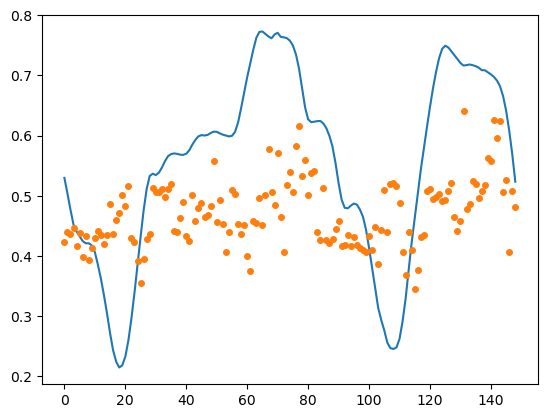

In [22]:
i, j = 3, 20
plt.plot(targets[i][j][:, 0])
plt.plot(pred[i][j][:, 0], linestyle="None", marker="o", markersize=4)

In [23]:
lag = 1
features = ('mav', ('zc', 0.003), ('ssc', 0.0003), 'wl') 

targets, inputs = prepare_data(train_data, 10, 1, 222 * lag, 50) 
inputs = get_feature_vector(inputs, *features, lag=lag)
inputs, norm_vals = norm_emg_data(inputs, "z")
targets, norm_vals_targets = norm_joints(targets)

In [24]:
model = load_model("models/Finn/feat_ex_models/model002/best_model.keras", custom_objects={"LeakyReLU": LeakyReLU})

In [28]:
mean_squared_error(model.predict(np.vstack(inputs)), np.vstack(targets))

5141/5141 ━━━━━━━━━━━━━━━━━━━━ 2s 454us/step


0.05286875367164612

In [26]:
norm_vals

(array([6.61019591e-03, 5.37034684e-03, 1.39840408e-02, 3.92939228e-03,
        9.14197710e-03, 8.51256121e-03, 2.14221762e-03, 3.62556363e-03,
        7.75311831e+00, 7.37503647e+00, 1.64964501e+01, 6.52861189e+00,
        7.13279882e+00, 7.80093853e+00, 2.47815357e+00, 3.94614375e+00,
        1.88036861e+01, 1.96080104e+01, 1.85553455e+01, 2.22058999e+01,
        1.82717856e+01, 1.70304112e+01, 2.41601099e+01, 2.15544702e+01,
        4.12837643e-01, 3.90839479e-01, 1.04714105e+00, 3.76800030e-01,
        5.47458747e-01, 5.26241697e-01, 2.25264581e-01, 2.73716921e-01]),
 array([5.25489837e-03, 4.84008322e-03, 6.44062551e-03, 2.92883954e-03,
        7.12362798e-03, 4.86825559e-03, 9.69332508e-04, 1.60555348e-03,
        4.38084501e+00, 4.85491645e+00, 5.03118432e+00, 4.96502265e+00,
        4.80603886e+00, 4.51297941e+00, 2.13507228e+00, 2.52990146e+00,
        4.94620561e+00, 4.18459952e+00, 3.10374466e+00, 3.67245287e+00,
        5.19959987e+00, 4.34728862e+00, 3.38309705e+00, 3.9497

In [27]:
norm_vals_targets

(np.float32(-29.542063), np.float32(156.82605))